# Exploratory Data Analysis

### COVID-19 Daily Infections and Deaths Data
#### Importing dataset

In [25]:
root_path = '/home/mbai/python/covid_ds/'
import sys
sys.path.append(root_path)

import pandas as pd
import numpy as np
import sqlite3
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from etl.constants import ETLConfigs
pd.options.mode.chained_assignment = None

conn = sqlite3.connect("{}{}.db".format(root_path, ETLConfigs.DB_NAME))
query = "SELECT * FROM {}".format(ETLConfigs.TABLE_NAME)

df = pd.read_sql_query(query, conn)

### Initial view of the dataset
Let's get a quick view of the scope and type of dataset we're dealing with:  
Looking at the top/bottom/random 20 rows, data shape, and datatypes

In [26]:
df.head()

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
0,Afghanistan,None,33.0000,65.0000,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
1,Albania,None,41.1533,20.1683,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
2,Algeria,None,28.0339,1.6596,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
3,Andorra,None,42.5063,1.5218,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386
4,Angola,None,-11.2027,17.8739,2020-01-22 00:00:00,0,0,2020-05-01 17:09:22.385386


In [27]:
df.tail()

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
352695,US,Utah,38.996171,-110.701396,2020-04-30 00:00:00,-2,0,2020-05-01 17:09:22.385386
352696,US,Utah,37.854472,-111.441876,2020-04-30 00:00:00,5,0,2020-05-01 17:09:22.385386
352697,US,Utah,40.124915,-109.517442,2020-04-30 00:00:00,2,0,2020-05-01 17:09:22.385386
352698,US,Utah,41.271160,-111.914512,2020-04-30 00:00:00,7,0,2020-05-01 17:09:22.385386
352699,US,Utah,NaN,NaN,2020-04-30 00:00:00,0,0,2020-05-01 17:09:22.385386


In [28]:
df.sample(10)

,country,state,latitude,longitude,date,confirmed,death,etl_load_time
332892,US,West Virginia,37.730484,-82.133384,2020-04-24 00:00:00,0,0,2020-05-01 17:09:22.385386
308303,US,Michigan,46.209741,-88.531363,2020-04-17 00:00:00,0,0,2020-05-01 17:09:22.385386
95957,US,Kansas,37.192366,-95.743293,2020-02-12 00:00:00,0,0,2020-05-01 17:09:22.385386
72553,US,Florida,30.197461,-82.990997,2020-02-05 00:00:00,0,0,2020-05-01 17:09:22.385386
296215,US,Oregon,42.792467,-120.385016,2020-04-13 00:00:00,0,0,2020-05-01 17:09:22.385386
278559,US,Iowa,41.335771,-91.717257,2020-04-08 00:00:00,5,0,2020-05-01 17:09:22.385386
284232,US,Alabama,34.442353,-87.842895,2020-04-10 00:00:00,0,0,2020-05-01 17:09:22.385386
98180,US,New Hampshire,0.000000,0.000000,2020-02-12 00:00:00,0,0,2020-05-01 17:09:22.385386
191644,US,North Dakota,48.368770,-97.725748,2020-03-12 00:00:00,0,0,2020-05-01 17:09:22.385386
86688,US,Mississippi,33.601926,-90.588827,2020-02-09 00:00:00,0,0,2020-05-01 17:09:22.385386


In [29]:
df.shape
num_rows = df.shape[0]
num_cols = df.shape[1]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352700 entries, 0 to 352699
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   country        352700 non-null  object 
 1   state          334400 non-null  object 
 2   latitude       352600 non-null  float64
 3   longitude      352600 non-null  float64
 4   date           352700 non-null  object 
 5   confirmed      352700 non-null  int64  
 6   death          352700 non-null  int64  
 7   etl_load_time  352700 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 21.5+ MB


In [31]:
df.dtypes

country           object
state             object
latitude         float64
longitude        float64
date              object
confirmed          int64
death              int64
etl_load_time     object
dtype: object

### A few observations here:

- We have 350k rows of data and 8 columns
- country, state, longitude, and latitude denoting location in the world (labels)
- state has `None` as null value
- confirmed and death for potential prediction (target)
- date and etl_load_time seems to be stored as `string` rather than `datetime`
- `etl_load_time` seems obsolete for this purpose

Let's drop `etl_load_time` and convert `date` to the proper datatype

In [32]:
df['date'] = df['date'].astype('datetime64', copy=False)
df.drop(columns=['etl_load_time'], inplace=True, errors='ignore')
df.replace({None: np.NaN}, inplace=True)

df.dtypes

country              object
state                object
latitude            float64
longitude           float64
date         datetime64[ns]
confirmed             int64
death                 int64
dtype: object

### Searching and dealing with *null*

Figure out the scope of the nulls  
Visualize missing values with missingno  

In [33]:
print(f"Out of {num_rows} rows")
for i in df:
    missing = df[i].isnull().sum()
    miss_perc = round(missing / num_rows, 3)
    print(f"Row {i} has {missing} nulls, or about {miss_perc}%")

Out of 352700 rows
Row country has 0 nulls, or about 0.0%
Row state has 18300 nulls, or about 0.052%
Row latitude has 100 nulls, or about 0.0%
Row longitude has 100 nulls, or about 0.0%
Row date has 0 nulls, or about 0.0%
Row confirmed has 0 nulls, or about 0.0%
Row death has 0 nulls, or about 0.0%


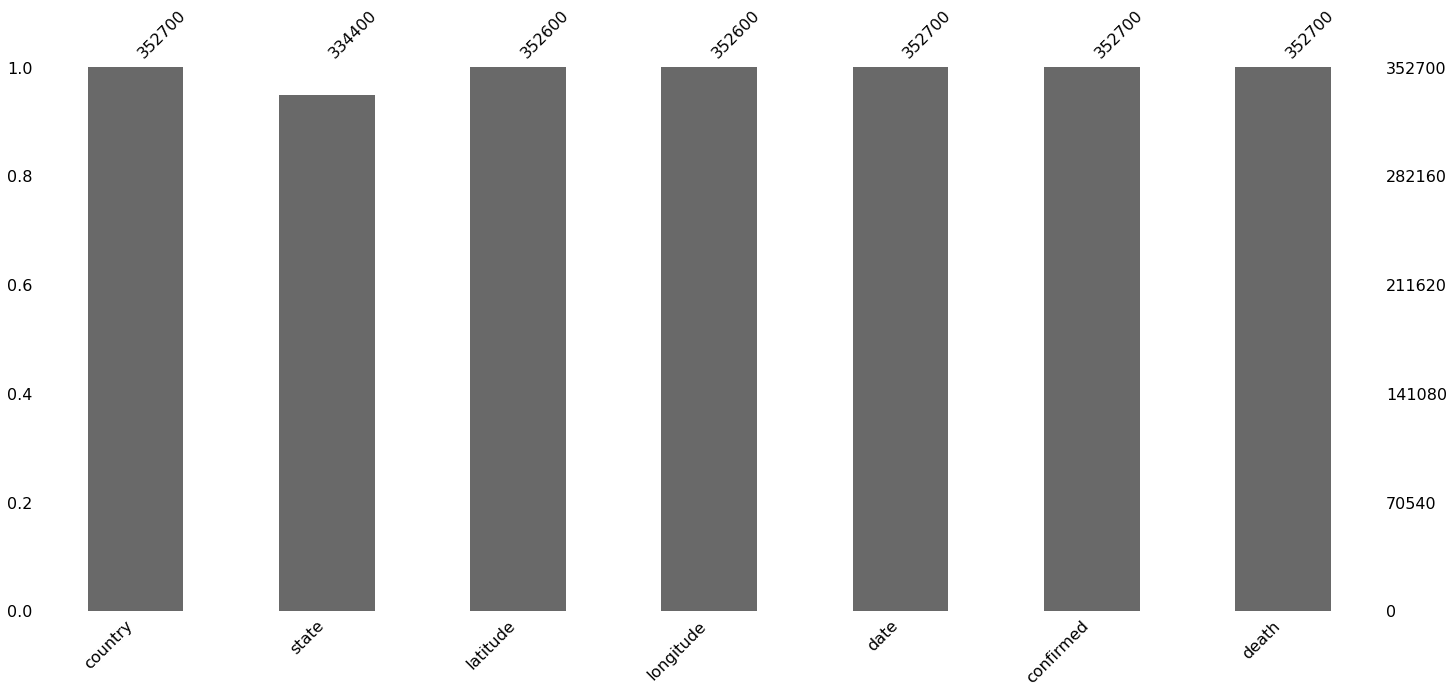

In [34]:
msno.bar(df)

Looks like `longitude` and `latitude` labels both has a small numbers of nulls  
Let's see which index they are are originating form, based on their country and state

In [35]:
log_lat_null_df = df[(
    ((df["longitude"].isnull()) & (df["latitude"].isnull()))
)]
print(log_lat_null_df['country'].unique())
print(log_lat_null_df['state'].unique())

['US']
['Utah']


Okay... US and Utah. See if they normally have any values?

In [36]:
log_lat_null_df.groupby(["country"]).sum()

,latitude,longitude,confirmed,death
country,,,,
US,0.0,0.0,0,0


Nice. No useful values. Let's drop

In [37]:
df_null_step1 = df[(
        ~((df["longitude"].isnull()) & (df["latitude"].isnull()))
    )]
print(f"Previous rows were {num_rows}")
new_num_rows = df_null_step1.shape[0]
print(f"Now there are {new_num_rows}")

Previous rows were 352700
Now there are 352600


Let's repeat for the nulls in state  
Gut feeling is that they are based on countries

In [38]:
country_null_df = df_null_step1[(
    df_null_step1["state"].isnull()
)]

print(country_null_df["country"].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Austria' 'Azerbaijan'
 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Central African Republic' 'Chad' 'Chile' 'Colombia'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Holy See' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Lebanon' 'Liberia' 'Liechtenstein' 'Lith

Easiest way to fill these nulls would be to clone the data from countries label for all the countries that we do not have state level data  
For analysis we can later decide whether to group everything at `country` level or treat each `state` as an independent entity

In [39]:
df_null_step1["state"].fillna(df_null_step1["country"], inplace=True)

In [44]:
df_null_step1.info()
df_ready = df_null_step1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352600 entries, 0 to 352698
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   country    352600 non-null  object        
 1   state      352600 non-null  object        
 2   latitude   352600 non-null  float64       
 3   longitude  352600 non-null  float64       
 4   date       352600 non-null  datetime64[ns]
 5   confirmed  352600 non-null  int64         
 6   death      352600 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 31.5+ MB


### Fiding Outliners and deiciding what to do

Taking a look a the daily increments on confirmed and death cases

In [45]:
df_ready["confirmed"].describe()

count    352600.000000
mean          9.236679
std         155.085954
min      -10034.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       26843.000000
Name: confirmed, dtype: float64

In [46]:
df_ready["death"].describe()

count    352600.000000
mean          0.661906
std          16.524069
min        -658.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1438.000000
Name: death, dtype: float64

Interesting.. some people resurrected from being dead  
See where the outlier or errata of negative increments are happening

In [52]:
df_nkk = df_ready[df_ready["confirmed"]<0]
df_nd = df_ready[df_ready["death"]<0]

print("Countries with negative daily confirmed cases:")
print(df_nkk["country"].unique())
print("Countries with negative daily death cases:")
print(df_nd["country"].unique())

Countries with negative daily confirmed cases:
['Australia' 'France' 'China' 'Guyana' 'Canada' 'United Kingdom' 'Uruguay'
 'Uganda' 'Spain' 'West Bank and Gaza' 'New Zealand' 'Japan' 'Lithuania'
 'Mauritius' 'US']
Countries with negative daily death cases:
['Iceland' 'Philippines' 'India' 'Kazakhstan' 'Canada' 'Slovakia' 'Serbia'
 'Cyprus' 'Finland' 'Germany' 'Luxembourg' 'West Bank and Gaza' 'US']


Let's visualize by frequency by countries

In [60]:
df_nkk_plot_sum = df_negative_kk.groupby(by="country").sum()
df_nkk_plot_cnt = df_negative_kk.groupby(by="country").count()

In [103]:
def plot_neg_scatter(df, x_axis, y_axis, category):
    data_df = df.reset_index()
    sns.set(rc={'figure.figsize':(20,5)})
    sns.set_style("dark")
    plt.title(f"Negative {y_axis} cases by {x_axis} on {category} of {y_axis}")
    sns.barplot(
        data=data_df,
        x=x_axis,
        y=y_axis,
    ).invert_yaxis()

,latitude,longitude,confirmed,death
country,,,,
US,59985.165005,-143246.323724,-28403,-35
Spain,40.000000,-4.000000,-10034,367
France,135.678500,109.425800,-4738,1613
Japan,36.000000,138.000000,-417,9
West Bank and Gaza,31.952200,35.233200,-142,-2
Lithuania,55.169400,23.881300,-105,3
Guyana,5.000000,-58.750000,-15,0
Uruguay,-32.522800,-55.765800,-14,0
Canada,212.083500,-358.374000,-10,32


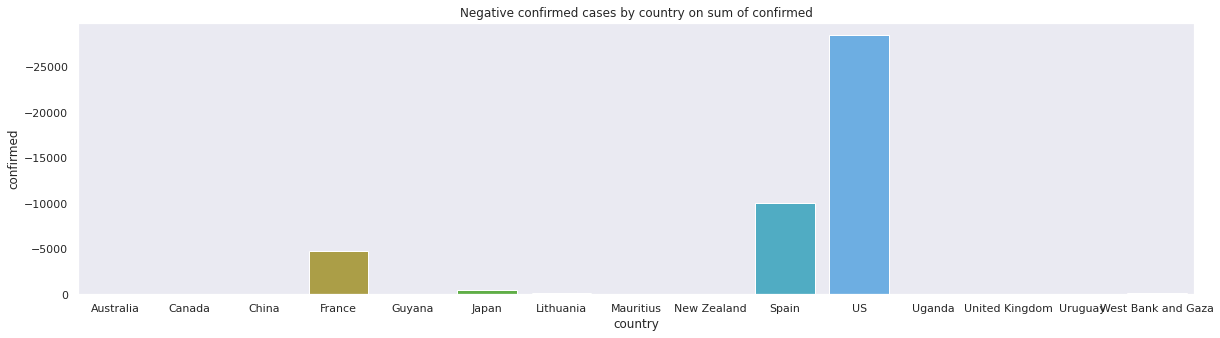

In [104]:
plot_neg_scatter(df_nkk_plot_sum, "country", "confirmed", "sum")
df_nkk_plot_sum.sort_values(by="confirmed", ascending=True).head(10)

In [102]:
plot_neg_scatter(df_nkk_plot_sum, "state", "confirmed", "sum")
df_nkk_plot_sum.sort_values(by="confirmed", ascending=True).head(10)

ValueError: Could not interpret input 'state'